# Predicting beer consumption

Online class on Supervised Learning, Wednesday, 05th of November 2025

For BIP "Machine Learning for Data Science"

## Importing required modules

In [136]:
# Install packages for the project
# !pip install pandas numpy seaborn matplotlib scikit-learn scipy networkx tensorflow

In [137]:
# Import the required building blocks

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Import your models here for a clean look
# from ... import ...
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


# Beer consumption as a classification issue
Let's try to predict whether "very little", "little", "much" or "very much" beer is drunk; A classification.

To this end, the data is processed in which the number of Litres is divided into four classes.
The limit of the classes is roughly based on the quartile distribution.

- I: under 22,000 Litres
- II: between 22,000 and 25,000 Litres
- III: between 25,000 and 29,000 Litres
- IV: More than 29,000 Litres

If all goes well, these classes are of comparable size (i.e. somewhat balanced).

## Data analysis and preprocessing

In [138]:
# Back to the source
df = pd.read_csv('Beerconsumption.csv')
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Weekend = df.Weekend.astype(int)

### Making classes

In [139]:
# Making the classes (this is one method, many exist)
df['Class1'] = np.where(df['Litres'] > 29000, 1, 0)
df['Class2'] = np.where(df['Litres'] > 25000, 1, 0)
df['Class3'] = np.where(df['Litres'] > 22000, 1, 0)
df['Class4'] = np.where(df['Litres'] > 10000, 1, 0)

df['Class'] = df.Class1 + df.Class2 + df.Class3 + df.Class4
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class1,Class2,Class3,Class4,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,0,1,1,1,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,0,1,1,1,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,1,1,1,1,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,1,1,1,1,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,0,1,1,1,3


In [140]:
# The auxiliary columns can leave again
df.drop(columns=['Class1', 'Class2', 'Class3', 'Class4'], inplace=True)
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,3


      Litres                                                       
       count        sum     mean     std      min   median      max
Class                                                              
1         90  1808614.0  20095.7  1672.7  14343.0  20597.5  21979.0
2         98  2309777.0  23569.2   942.3  22001.0  23551.5  24974.0
3         95  2560159.0  26949.0  1163.6  25070.0  26828.0  28979.0
4         82  2592949.0  31621.3  1985.8  29090.0  31134.0  37937.0


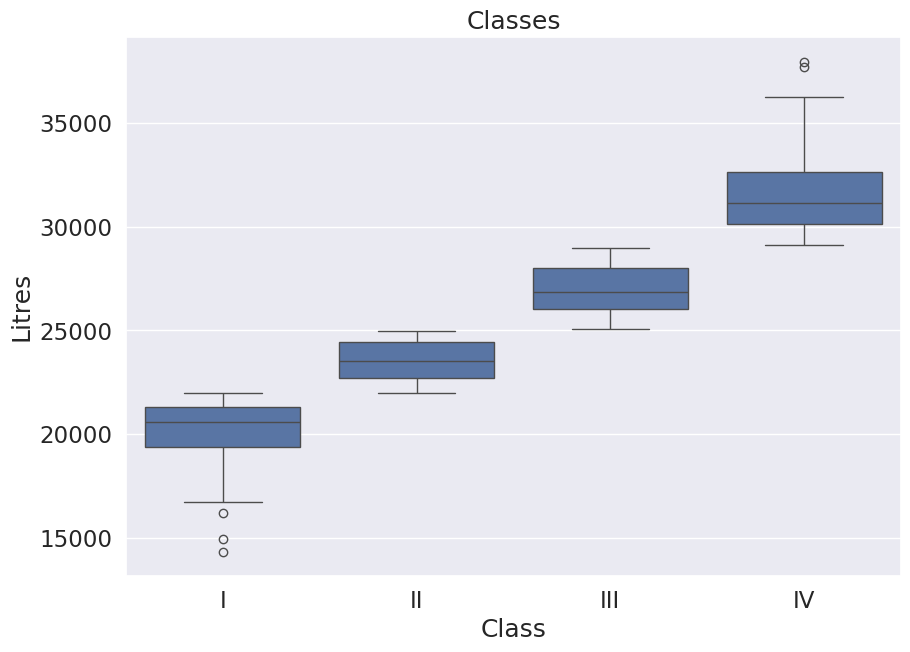

In [141]:
# Just a check of the number of Litres per class
perClass = df.groupby('Class').agg({'Litres':['count','sum','mean','std','min','median', 'max']}).round(1)
print(perClass)

plt.figure(figsize=(10,7))
sns.boxplot(x="Class", y="Litres", data=df)
plt.xticks(range(0,4),["I", "II", "III", "IV"])
plt.title("Classes")
plt.show()

### 1. Feature selection
Is the Date a useful feature for our goal? Would another be useful? How can you check?

In [142]:
# Let's add the season, because why not
df['Season'] = df.Date.dt.month.map({1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1})

In [143]:
df['Season'].unique()

array([1, 2, 3, 4])

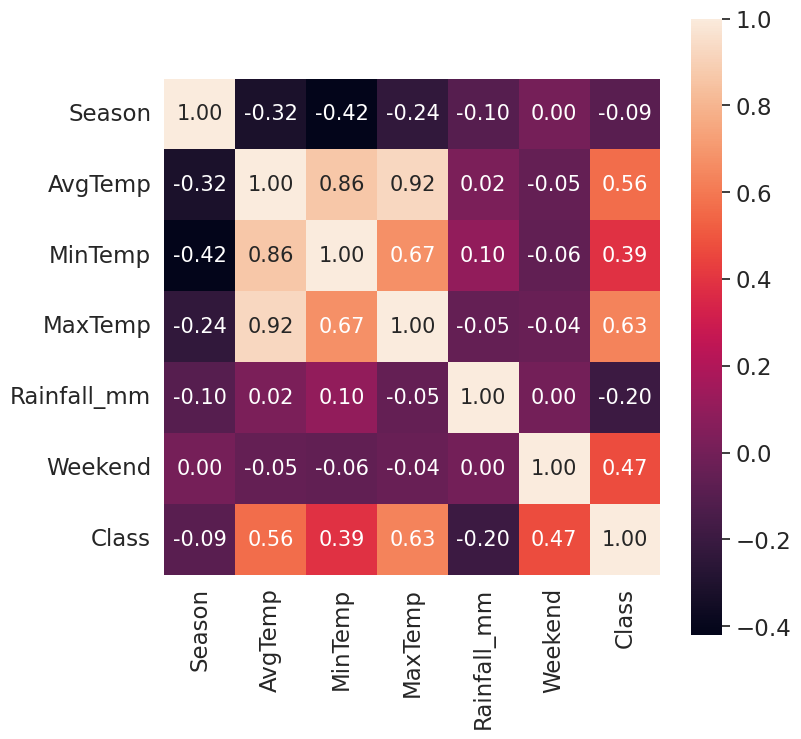

In [144]:
# Plot the correlation matrix for all features except the date
kolomdf = ['Season', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Class']

feature_names = kolomdf[:-1]  # Exclude 'Class' for feature names

plt.figure(figsize=(8,8))
cm = np.corrcoef(df[kolomdf].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=kolomdf,
                xticklabels=kolomdf
                )
plt.show()

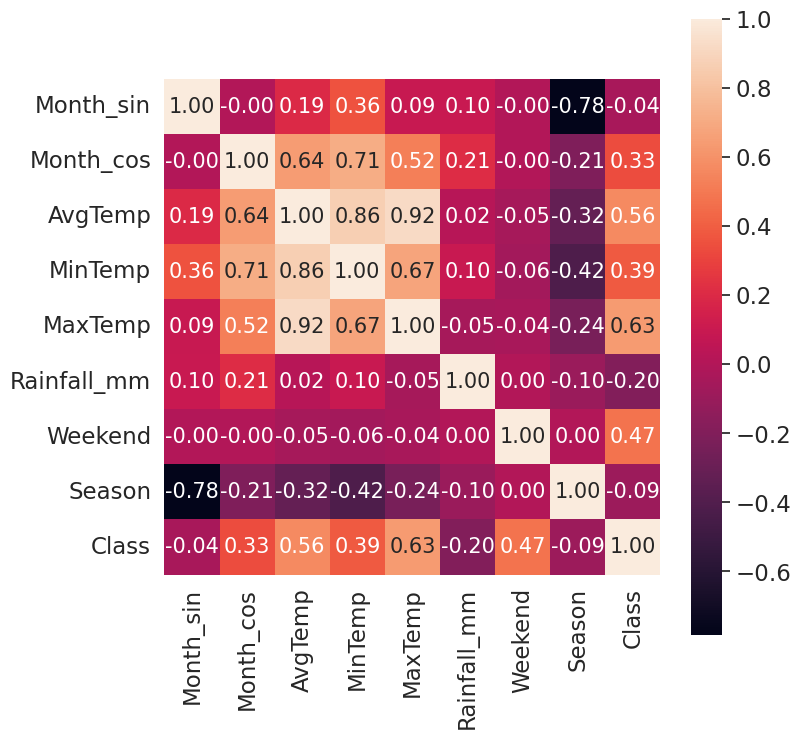

In [145]:
import numpy as np

# Extract month from the date
df['Month'] = df['Date'].dt.month

# Cyclical encoding: preserves continuity (January and December are close)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

features_and_target = ['Month_sin', 'Month_cos', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Season', 'Class']
plt.figure(figsize=(8,8))
cm = np.corrcoef(df[features_and_target].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=features_and_target,
                xticklabels=features_and_target
                )
plt.show()


We'll make a simple model, using only MaxTemp and Weekend as features. AvgTemp and MinTemp are too strongly correlated with MaxTemp, and Rainfall and Season are only very weakly correlated with Class.

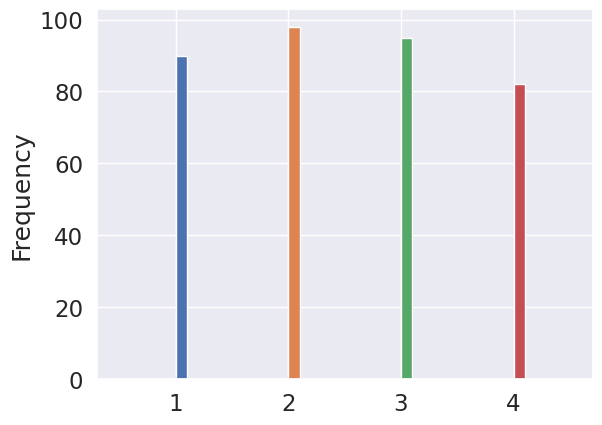

0      3
1      3
2      4
3      4
4      3
      ..
360    4
361    3
362    2
363    1
364    2
Name: Class, Length: 365, dtype: int64


In [146]:
# We'll use as the predictors/features/independent variables MaxTemp and Weekend,
# and the class is the value to be predicted (label/independent var)
labels = df.loc[:,'Class']

feature_names = ['MaxTemp', 'Weekend', 'Month_sin', 'Month_cos']

data = df.loc[:, feature_names]
# data = df.loc[:, feature_names]  # Using all features except 'Class'

# Insight into the frequency distribution of the classes;
# They are roughly balanced (as intended)
labels[:].groupby(labels[:]).plot(kind="hist")
plt.show()

print(labels)

In [147]:
data

,MaxTemp,Weekend,Month_sin,Month_cos
0,32.5,0,5.000000e-01,0.866025
1,33.5,0,5.000000e-01,0.866025
2,29.9,1,5.000000e-01,0.866025
3,28.6,1,5.000000e-01,0.866025
4,28.3,0,5.000000e-01,0.866025
...,...,...,...,...
360,28.2,1,-2.449294e-16,1.000000
361,26.7,0,-2.449294e-16,1.000000
362,24.1,0,-2.449294e-16,1.000000
363,22.4,0,-2.449294e-16,1.000000


In [148]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Suppose you already have your features and labels:
# data = ...
# labels = ...

# Define a consistent CV strategy (important for fair comparison)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define candidate models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model via cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, data, labels, cv=cv, scoring='accuracy')
    results[name] = (scores.mean(), scores.std())
    print(f"{name:20s} → mean acc: {scores.mean():.3f} ± {scores.std():.3f}")

# Optional: rank models by mean accuracy
print("\nRanked results:")
for name, (mean, std) in sorted(results.items(), key=lambda x: x[1][0], reverse=True):
    print(f"{name:20s} → {mean:.3f} ± {std:.3f}")


Decision Tree        → mean acc: 0.548 ± 0.058
Random Forest        → mean acc: 0.567 ± 0.024
Gradient Boosting    → mean acc: 0.567 ± 0.055
Logistic Regression  → mean acc: 0.578 ± 0.041
Support Vector Machine → mean acc: 0.458 ± 0.052
Naive Bayes          → mean acc: 0.553 ± 0.037

Ranked results:
Logistic Regression  → 0.578 ± 0.041
Random Forest        → 0.567 ± 0.024
Gradient Boosting    → 0.567 ± 0.055
Naive Bayes          → 0.553 ± 0.037
Decision Tree        → 0.548 ± 0.058
Support Vector Machine → 0.458 ± 0.052


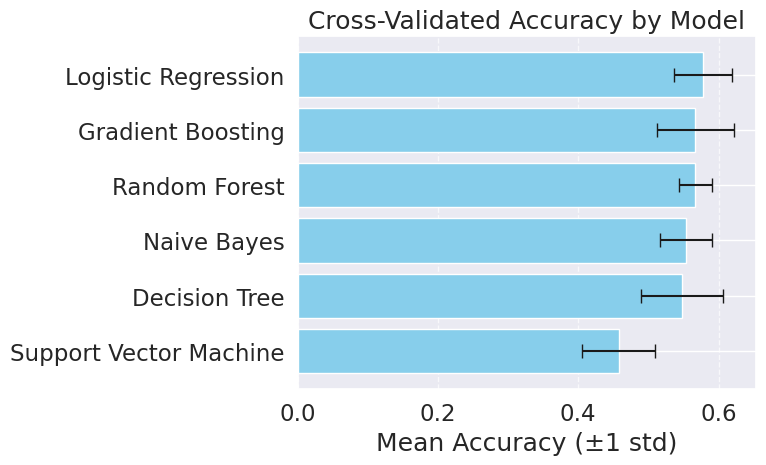

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names, means, and stds dynamically
model_names = list(results.keys())
means = np.array([v[0] for v in results.values()])
stds = np.array([v[1] for v in results.values()])

# Sort by mean accuracy
sorted_idx = np.argsort(means)
model_names = np.array(model_names)[sorted_idx]
means = means[sorted_idx]
stds = stds[sorted_idx]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(model_names, means, xerr=stds, capsize=5, color='skyblue')
plt.xlabel('Mean Accuracy (±1 std)')
plt.title('Cross-Validated Accuracy by Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import joblib
from sklearn.model_selection import train_test_split


# ==============================================
# 1️⃣ Hyperparameter tuning with cross-validation
# ==============================================
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # regularization strength
    'solver': ['lbfgs', 'saga'],    # solvers supporting multinomial loss
    'penalty': ['l2'],              # 'l1' or 'elasticnet' possible with saga
    'max_iter': [1000]
}

logreg = LogisticRegression(random_state=42)

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data,            # your feature matrix (e.g. DataFrame or NumPy array)
    labels,          # your target vector (e.g. Series or array)
    test_size=0.2,   # 20% for testing, 80% for training (you can adjust this)
    random_state=42, # ensures reproducibility
    stratify=labels  # keeps class proportions consistent across splits
)

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train = X_train_scaled
# X_test = X_test_scaled

grid.fit(X_train, y_train)

print(f"✅ Best parameters: {grid.best_params_}")
print(f"✅ Best CV accuracy: {grid.best_score_:.3f}")

# ==============================================
# 2️⃣ Train final model on the entire training set
# ==============================================
final_model = grid.best_estimator_
final_model.fit(X_train, y_train)

# ==============================================
# 3️⃣ Evaluate on the hold-out test set
# ==============================================
y_pred = final_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(f"\n Test accuracy: {test_acc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# # ==============================================
# # 4️⃣ Visualize confusion matrix
# # ==============================================
# plt.figure(figsize=(6, 6))
# ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues', colorbar=False)
# plt.title("Confusion Matrix — Final Logistic Regression Model")
# plt.tight_layout()
# plt.show()

# print(final_model.coef_.shape)  # (n_classes, n_features)
# print(len(feature_names))       # should equal n_features

# ==============================================
# 5️⃣ Inspect coefficients (interpretability)
# ==============================================
coef_df = pd.DataFrame(final_model.coef_, columns=feature_names)
coef_df.index = [f'Class {i}' for i in range(coef_df.shape[0])]
print("\nFeature coefficients per class:")
display(coef_df)

# ==============================================
# 6️⃣ Save model for reuse/deployment
# ==============================================
joblib.dump(final_model, "logreg_final_model.pkl")
print("\n Model saved as logreg_final_model.pkl")


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

✅ Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
✅ Best CV accuracy: 0.583

 Test accuracy: 0.548

Classification report:
               precision    recall  f1-score   support

           1       0.76      0.72      0.74        18
           2       0.41      0.35      0.38        20
           3       0.38      0.42      0.40        19
           4       0.67      0.75      0.71        16

    accuracy                           0.55        73
   macro avg       0.56      0.56      0.56        73
weighted avg       0.55      0.55      0.55        73


Feature coefficients per class:


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,MaxTemp,Weekend,Month_sin,Month_cos
Class 0,-0.562341,-2.951212,0.690068,0.043833
Class 1,-0.131224,-1.042786,0.019637,-0.151818
Class 2,0.160057,0.735009,-0.100658,0.160700
Class 3,0.533507,3.258989,-0.609047,-0.052715



 Model saved as logreg_final_model.pkl


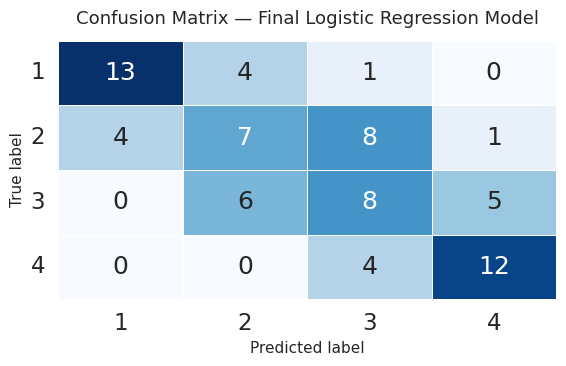

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (optional)
labels = final_model.classes_  # or list like ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plot using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,            # show values inside cells
    fmt='d',               # integer format
    cmap='Blues',          # color scheme
    xticklabels=labels,    # custom tick labels
    yticklabels=labels,
    cbar=False,            # remove colorbar for cleaner look
    linewidths=0.5,        # thin borders between cells
    linecolor='white'      # optional: makes light cell separation
)

plt.title("Confusion Matrix — Final Logistic Regression Model", fontsize=13, pad=12)
plt.xlabel("Predicted label", fontsize=11)
plt.ylabel("True label", fontsize=11)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Nested cross-validation

In [156]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

# ==========================================
# 1️⃣ Define CV strategy
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# 2️⃣ Define models and search spaces
# ==========================================
search_spaces = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {
            "C": uniform(0.01, 10),
            "solver": ["lbfgs", "saga"],
            "penalty": ["l2"],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 300),
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": randint(2, 10),
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(2, 6),
        },
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": uniform(0.1, 10),
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"],
        },
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {},  # no hyperparameters to tune
    },
}

# ==========================================
# 3️⃣ Run RandomizedSearchCV for each model
# ==========================================
results = []

for name, cfg in search_spaces.items():
    print(f"🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        estimator=cfg["model"],
        param_distributions=cfg["params"],
        n_iter=10,            # number of random combinations
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
    )
    search.fit(X_train, y_train)
    results.append({
        "Model": name,
        "Best Accuracy": search.best_score_,
        "Best Params": search.best_params_,
    })

# ==========================================
# 4️⃣ Summarize results
# ==========================================
df_results = pd.DataFrame(results).sort_values("Best Accuracy", ascending=False)
print("\n📊 Cross-validated results with tuned hyperparameters:")
display(df_results)

# Optional: evaluate best model on test set
best_model_name = df_results.iloc[0]["Model"]
best_params = df_results.iloc[0]["Best Params"]
print(f"\n🏆 Best model: {best_model_name}")
print("Best params:", best_params)


🔍 Tuning Logistic Regression...


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

🔍 Tuning Random Forest...
🔍 Tuning Gradient Boosting...
🔍 Tuning SVM...
🔍 Tuning Naive Bayes...

📊 Cross-validated results with tuned hyperparameters:


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,Model,Best Accuracy,Best Params
3,SVM,0.612858,"{'C': 7.41993941811405, 'gamma': 'scale', 'ker..."
1,Random Forest,0.595733,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."
0,Logistic Regression,0.588954,"{'C': 4.468327528535911, 'penalty': 'l2', 'sol..."
2,Gradient Boosting,0.561601,"{'learning_rate': 0.15639878836228102, 'max_de..."
4,Naive Bayes,0.558153,{}



🏆 Best model: SVM
Best params: {'C': 7.41993941811405, 'gamma': 'scale', 'kernel': 'linear'}


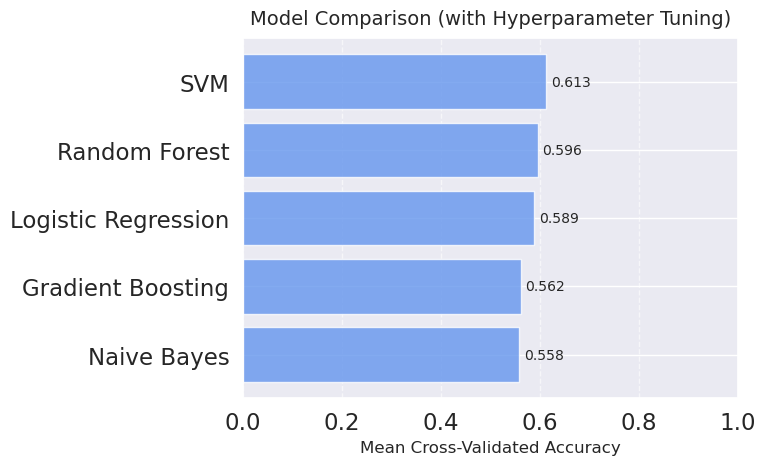

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: compute std from RandomizedSearchCV results (if stored)
# If you kept search.cv_results_ in the loop, you could compute per-model std.
# For simplicity, assume equal stds here — you can skip xerr if not computed.

# Sort by accuracy
df_sorted = df_results.sort_values("Best Accuracy", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(
    df_sorted["Model"],
    df_sorted["Best Accuracy"],
    color="cornflowerblue",
    alpha=0.8
)
plt.xlabel("Mean Cross-Validated Accuracy", fontsize=12)
plt.title("Model Comparison (with Hyperparameter Tuning)", fontsize=14, pad=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, 1)  # Accuracy always between 0 and 1

# Annotate accuracy values
for i, (acc, model) in enumerate(zip(df_sorted["Best Accuracy"], df_sorted["Model"])):
    plt.text(acc + 0.01, i, f"{acc:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


🔍 Tuning Logistic Regression...


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

🔍 Tuning Random Forest...
🔍 Tuning Gradient Boosting...
🔍 Tuning SVM...
🔍 Tuning Naive Bayes...

📊 Cross-validated results with tuned hyperparameters:


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,Model,Mean Accuracy,Std,Best Params
3,SVM,0.612858,0.051089,"{'C': 7.41993941811405, 'gamma': 'scale', 'ker..."
1,Random Forest,0.595733,0.006391,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."
0,Logistic Regression,0.588954,0.028542,"{'C': 4.468327528535911, 'penalty': 'l2', 'sol..."
2,Gradient Boosting,0.561601,0.014492,"{'learning_rate': 0.15639878836228102, 'max_de..."
4,Naive Bayes,0.558153,0.000000,{}


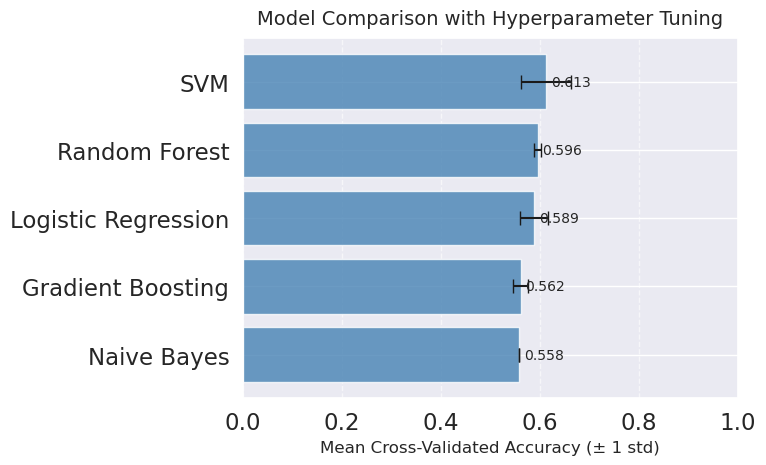

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint, uniform

# ==========================================
# 1️⃣ CV strategy
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# 2️⃣ Model definitions and parameter spaces
# ==========================================
search_spaces = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {
            "C": uniform(0.01, 10),
            "solver": ["lbfgs", "saga"],
            "penalty": ["l2"],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 300),
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": randint(2, 10),
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 300),
            "learning_rate": uniform(0.01, 0.2),
            "max_depth": randint(2, 6),
        },
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": uniform(0.1, 10),
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"],
        },
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {},  # no hyperparameters to tune
    },
}

# ==========================================
# 3️⃣ Run RandomizedSearchCV for each model
# ==========================================
results = []

for name, cfg in search_spaces.items():
    print(f"🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        estimator=cfg["model"],
        param_distributions=cfg["params"],
        n_iter=10,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
        return_train_score=False,
    )
    search.fit(X_train, y_train)
    mean_acc = search.best_score_
    std_acc = np.std(search.cv_results_["mean_test_score"])
    best_params = search.best_params_
    
    results.append({
        "Model": name,
        "Mean Accuracy": mean_acc,
        "Std": std_acc,
        "Best Params": best_params,
    })

# ==========================================
# 4️⃣ Display results table
# ==========================================
df_results = pd.DataFrame(results).sort_values("Mean Accuracy", ascending=False)
print("\n📊 Cross-validated results with tuned hyperparameters:")
display(df_results)

# ==========================================
# 5️⃣ Visualize with error bars
# ==========================================
df_sorted = df_results.sort_values("Mean Accuracy", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(
    df_sorted["Model"],
    df_sorted["Mean Accuracy"],
    xerr=df_sorted["Std"],
    capsize=5,
    color="steelblue",
    alpha=0.8
)
plt.xlabel("Mean Cross-Validated Accuracy (± 1 std)", fontsize=12)
plt.title("Model Comparison with Hyperparameter Tuning", fontsize=14, pad=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Annotate bars with mean accuracies
for i, (acc, model) in enumerate(zip(df_sorted["Mean Accuracy"], df_sorted["Model"])):
    plt.text(acc + 0.01, i, f"{acc:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()
